In [1]:
import os
import PIL
import math

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from IPython.display import display
from tensorflow.keras.preprocessing.image import load_img
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import img_to_array
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [2]:
# Load BSDS500 datsaset

dataset_url = "http://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz"
data_dir = keras.utils.get_file(origin = dataset_url, fname = "BSR", untar = True)
root_dir = os.path.join(data_dir, "BSDS500/data")

70770688/70763455 [==============================] - 1s 0us/step


In [3]:
# Create generator dataset object

crop_size = 300
upscale_factor = 3
input_size = crop_size // upscale_factor
batch_size = 8

train_ds = image_dataset_from_directory(
    root_dir,
    batch_size = batch_size,
    image_size = (crop_size, crop_size),
    validation_split = 0.2,
    subset = "training",
    seed = 42,
    label_mode = None,
)

valid_ds = image_dataset_from_directory(
    root_dir,
    batch_size = batch_size,
    image_size = (crop_size, crop_size),
    validation_split = 0.2,
    subset = "validation",
    seed = 42,
    label_mode = None,
)

Found 500 files belonging to 2 classes.
Using 400 files for training.
Found 500 files belonging to 2 classes.
Using 100 files for validation.


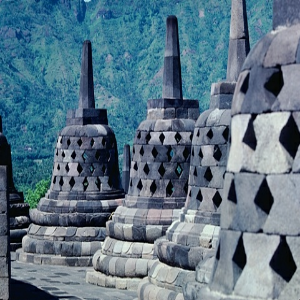

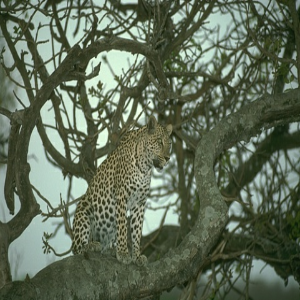

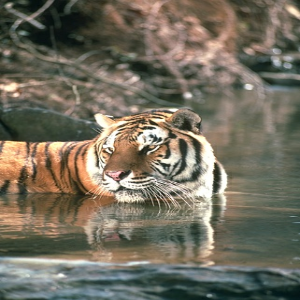

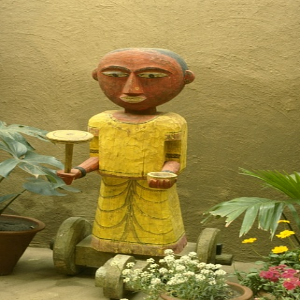

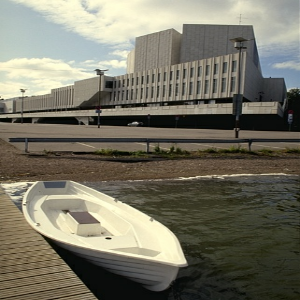

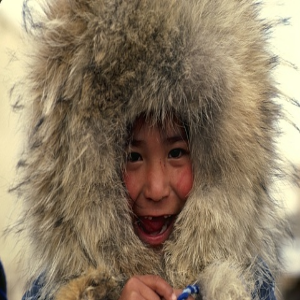

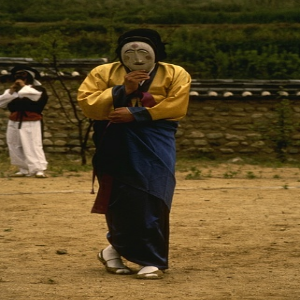

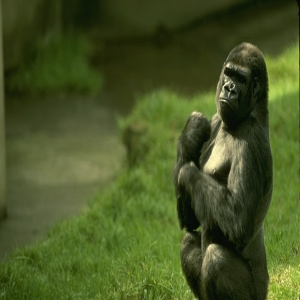

In [4]:
def scaling(input_image):
    input_image = input_image / 255.0
    return input_image

train_ds = train_ds.map(scaling)
valid_ds = valid_ds.map(scaling)

for batch in train_ds.take(1):
    for img in batch:
        display(array_to_img(img))

In [5]:
dataset = os.path.join(root_dir, "images")
test_path = os.path.join(dataset, "test")

test_img_paths = sorted(
    [
        os.path.join(test_path, fname)
        for fname in os.listdir(test_path)
        if fname.endswith(".jpg")
    ]
)

### Image Preprocessing

In [6]:
def process_input(input, input_size, upscale_factor):
    input = tf.image.rgb_to_yuv(input)
    last_dimension_axis = len(input.shape) - 1
    y, u, v = tf.split(input, 3, axis=last_dimension_axis)
    return tf.image.resize(y, [input_size, input_size], method = "area")


def process_target(input):
    input = tf.image.rgb_to_yuv(input)
    last_dimension_axis = len(input.shape) - 1
    y, u, v = tf.split(input, 3, axis = last_dimension_axis)
    return y


train_ds = train_ds.map(
    lambda x: (process_input(x, input_size, upscale_factor), process_target(x))
)
train_ds = train_ds.prefetch(buffer_size = 32)

valid_ds = valid_ds.map(
    lambda x: (process_input(x, input_size, upscale_factor), process_target(x))
)
valid_ds = valid_ds.prefetch(buffer_size = 32)

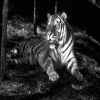

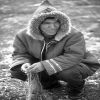

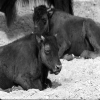

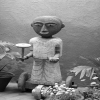

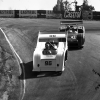

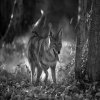

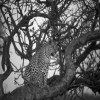

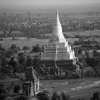

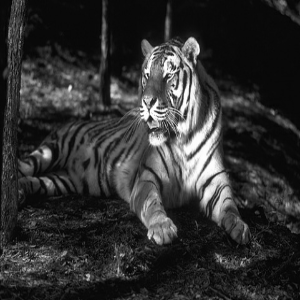

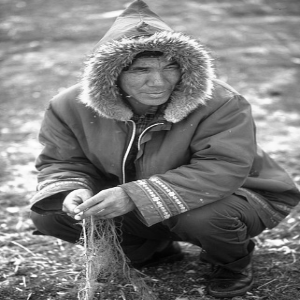

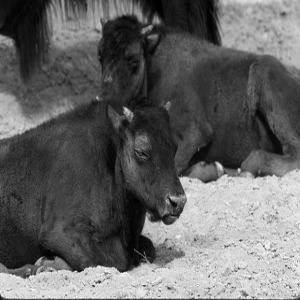

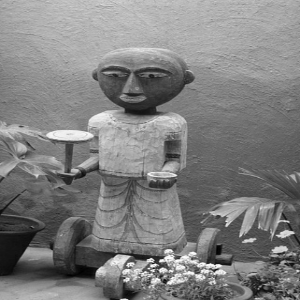

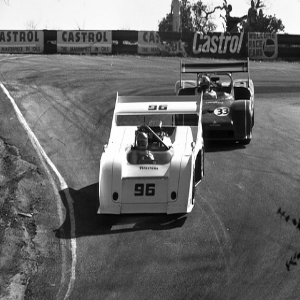

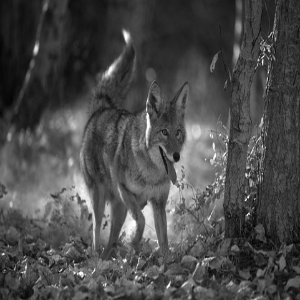

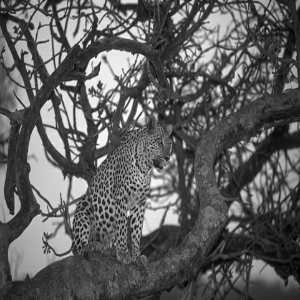

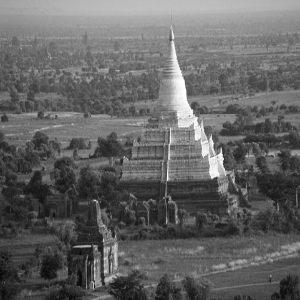

In [7]:
for batch in train_ds.take(1):
    for img in batch[0]:
        display(array_to_img(img))
    for img in batch[1]:
        display(array_to_img(img))

### Build the Model

In [8]:
def get_model(upscale_factor = 3, channels = 1):
    conv_args = {
        "activation": "relu",
        "kernel_initializer": "Orthogonal",
        "padding": "same",
    }
    inputs = keras.Input(shape = (None, None, channels))
    x = layers.Conv2D(64, 5, **conv_args)(inputs)
    x = layers.Conv2D(64, 3, **conv_args)(x)
    x = layers.Conv2D(32, 3, **conv_args)(x)
    x = layers.Conv2D(channels * (upscale_factor ** 2), 3, **conv_args)(x)
    outputs = tf.nn.depth_to_space(x, upscale_factor)

    return keras.Model(inputs, outputs)

### Utility Functions to monitor our results

In [9]:
def plot_results(img, prefix, title):
    """Plot the result with zoom-in area."""
    img_array = img_to_array(img)
    img_array = img_array.astype("float32") / 255.0

    # Create a new figure with a default 111 subplot.
    fig, ax = plt.subplots()
    im = ax.imshow(img_array[::-1], origin = "lower")

    plt.title(title)
    # zoom-factor: 2.0, location: upper-left
    axins = zoomed_inset_axes(ax, 2, loc = 2)
    axins.imshow(img_array[::-1], origin = "lower")

    # Specify the limits.
    x1, x2, y1, y2 = 200, 300, 100, 200
    # Apply the x-limits.
    axins.set_xlim(x1, x2)
    # Apply the y-limits.
    axins.set_ylim(y1, y2)

    plt.yticks(visible = False)
    plt.xticks(visible = False)

    # Make the line.
    mark_inset(ax, axins, loc1 = 1, loc2 = 3, fc = "none", ec = "blue")
    plt.savefig(str(prefix) + "-" + title + ".png")
    plt.show()


def get_lowres_image(img, upscale_factor):
    """Return low-resolution image to use as model input."""
    return img.resize(
        (img.size[0] // upscale_factor, img.size[1] // upscale_factor),
        PIL.Image.BICUBIC,
    )


def upscale_image(model, img):
    """Predict the result based on input image and restore the image as RGB."""
    ycbcr = img.convert("YCbCr")
    y, cb, cr = ycbcr.split()
    y = img_to_array(y)
    y = y.astype("float32") / 255.0

    input = np.expand_dims(y, axis = 0)
    out = model.predict(input)

    out_img_y = out[0]
    out_img_y *= 255.0

    # Restore the image in RGB color space.
    out_img_y = out_img_y.clip(0, 255)
    out_img_y = out_img_y.reshape((np.shape(out_img_y)[0], np.shape(out_img_y)[1]))
    out_img_y = PIL.Image.fromarray(np.uint8(out_img_y), mode = "L")
    out_img_cb = cb.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img_cr = cr.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img = PIL.Image.merge("YCbCr", (out_img_y, out_img_cb, out_img_cr)).convert(
        "RGB"
    )
    return out_img

### Custom Callbacks

In [10]:
class ESPCNCallback(keras.callbacks.Callback):
    def __init__(self):
        super(ESPCNCallback, self).__init__()
        self.test_img = get_lowres_image(load_img(test_img_paths[0]), upscale_factor)

    # Store PSNR value in each epoch.
    def on_epoch_begin(self, epoch, logs=None):
        self.psnr = []

    def on_epoch_end(self, epoch, logs=None):
        print("Mean PSNR for epoch: %.2f" % (np.mean(self.psnr)))
        if epoch % 20 == 0:
            prediction = upscale_image(self.model, self.test_img)
            plot_results(prediction, "epoch-" + str(epoch), "prediction")

    def on_test_batch_end(self, batch, logs=None):
        self.psnr.append(10 * math.log10(1 / logs["loss"]))

### Training

In [11]:
early_stopping_callback = keras.callbacks.EarlyStopping(monitor = "loss", patience = 10)

checkpoint_filepath = "/tmp/checkpoint"

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_filepath,
    save_weights_only = True,
    monitor = "loss",
    mode = "min",
    save_best_only = True,
)

model = get_model(upscale_factor = upscale_factor, channels = 1)
model.summary()

callbacks = [ESPCNCallback(), early_stopping_callback, model_checkpoint_callback]
loss_fn = keras.losses.MeanSquaredError()
optimizer = keras.optimizers.Adam(learning_rate = 0.001)

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 1)]   0         
_________________________________________________________________
conv2d (Conv2D)              (None, None, None, 64)    1664      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 64)    36928     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 32)    18464     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, None, None, 9)     2601      
_________________________________________________________________
tf_op_layer_DepthToSpace (Te [(None, None, None, 1)]   0         
Total params: 59,657
Trainable params: 59,657
Non-trainable params: 0
__________________________________________________

Epoch 1/100
47/50 [===========================>..] - ETA: 0s - loss: 0.0348Mean PSNR for epoch: 22.19


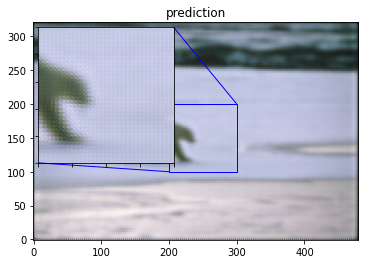

50/50 [==============================] - 2s 42ms/step - loss: 0.0331 - val_loss: 0.0063
Epoch 2/100
50/50 [==============================] - 2s 42ms/step - loss: 0.0051 - val_loss: 0.0037
Epoch 3/100
50/50 [==============================] - 2s 43ms/step - loss: 0.0034 - val_loss: 0.0030
Epoch 4/100
50/50 [==============================] - 2s 41ms/step - loss: 0.0030 - val_loss: 0.0028
Epoch 5/100
50/50 [==============================] - 2s 41ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 6/100
50/50 [==============================] - 2s 42ms/step - loss: 0.0029 - val_loss: 0.0027
Epoch 7/100
50/50 [==============================] - 2s 42ms/step - loss: 0.0028 - val_loss: 0.0026
Epoch 8/100
50/50 [==============================] - 2s 41ms/step - loss: 0.0027 - val_loss: 0.0026
Epoch 9/100
50/50 [==============================] - 2s 41ms/step - loss: 0.0027 - val_loss: 0.0026
Epoch 10/100
50/50 [==============================] - 2s 41ms/step - loss: 0.0028 - val_loss: 0.0026
Epoch 11/10

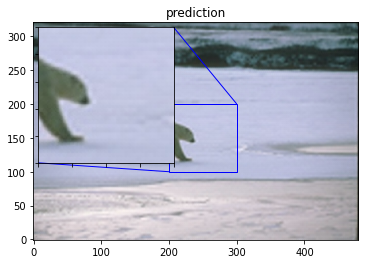

50/50 [==============================] - 3s 54ms/step - loss: 0.0026 - val_loss: 0.0025
Epoch 22/100
50/50 [==============================] - 2s 41ms/step - loss: 0.0027 - val_loss: 0.0025
Epoch 23/100
50/50 [==============================] - 2s 41ms/step - loss: 0.0026 - val_loss: 0.0025
Epoch 24/100
50/50 [==============================] - 2s 41ms/step - loss: 0.0026 - val_loss: 0.0025
Epoch 25/100
50/50 [==============================] - 2s 41ms/step - loss: 0.0026 - val_loss: 0.0025
Epoch 26/100
50/50 [==============================] - 2s 41ms/step - loss: 0.0026 - val_loss: 0.0025
Epoch 27/100
50/50 [==============================] - 2s 43ms/step - loss: 0.0026 - val_loss: 0.0025
Epoch 28/100
50/50 [==============================] - 2s 43ms/step - loss: 0.0026 - val_loss: 0.0025
Epoch 29/100
50/50 [==============================] - 2s 40ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 30/100
50/50 [==============================] - 2s 41ms/step - loss: 0.0026 - val_loss: 0.0025
Epo

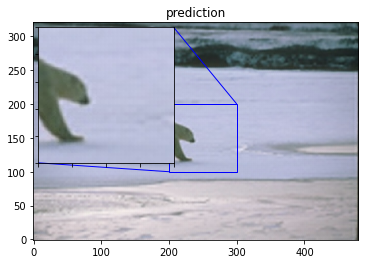

50/50 [==============================] - 3s 54ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 42/100
50/50 [==============================] - 2s 43ms/step - loss: 0.0027 - val_loss: 0.0025
Epoch 43/100
50/50 [==============================] - 2s 41ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 44/100
50/50 [==============================] - 2s 40ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 45/100
50/50 [==============================] - 2s 40ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 46/100
50/50 [==============================] - 2s 41ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 47/100
50/50 [==============================] - 2s 42ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 48/100
50/50 [==============================] - 2s 41ms/step - loss: 0.0026 - val_loss: 0.0025
Epoch 49/100
50/50 [==============================] - 2s 41ms/step - loss: 0.0026 - val_loss: 0.0025
Epoch 50/100
50/50 [==============================] - 2s 41ms/step - loss: 0.0026 - val_loss: 0.0024
Epo

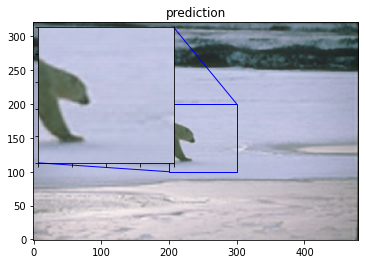

50/50 [==============================] - 3s 54ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 62/100
50/50 [==============================] - 2s 41ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 63/100
50/50 [==============================] - 2s 41ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 64/100
50/50 [==============================] - 2s 40ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 65/100
50/50 [==============================] - 2s 40ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 66/100
50/50 [==============================] - 2s 43ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 67/100
50/50 [==============================] - 2s 41ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 68/100
50/50 [==============================] - 2s 41ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 69/100
50/50 [==============================] - 2s 42ms/step - loss: 0.0025 - val_loss: 0.0030
Epoch 70/100
50/50 [==============================] - 2s 40ms/step - loss: 0.0027 - val_loss: 0.0024
Epo

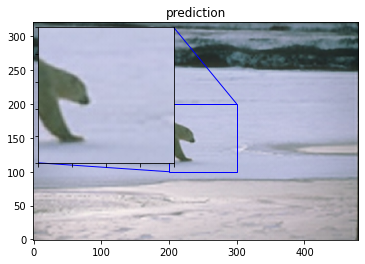

50/50 [==============================] - 3s 56ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 82/100
50/50 [==============================] - 2s 42ms/step - loss: 0.0025 - val_loss: 0.0028
Epoch 83/100
50/50 [==============================] - 2s 40ms/step - loss: 0.0026 - val_loss: 0.0024
Epoch 84/100
50/50 [==============================] - 2s 42ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 85/100
50/50 [==============================] - 2s 39ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 86/100
50/50 [==============================] - 2s 40ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 87/100
50/50 [==============================] - 2s 40ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 88/100
50/50 [==============================] - 2s 41ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 89/100
50/50 [==============================] - 2s 40ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 90/100
50/50 [==============================] - 2s 41ms/step - loss: 0.0025 - val_loss: 0.0024
Epo

In [12]:
epochs = 100

model.compile(
    optimizer = optimizer, loss = loss_fn,
)

model.fit(
    train_ds, epochs = epochs, callbacks = callbacks, validation_data = valid_ds, verbose = 1
)

# The model weights (that are considered the best) are loaded into the model.
model.load_weights(checkpoint_filepath)

### Predict

PSNR of low resolution image and high resolution image is 29.8502
PSNR of predict and high resolution is 30.3879


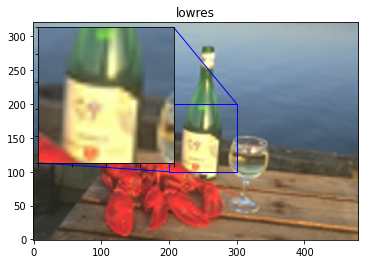

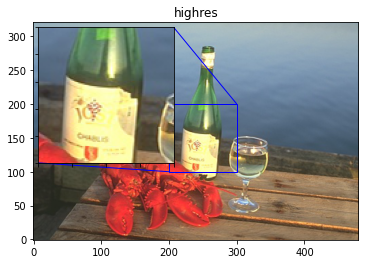

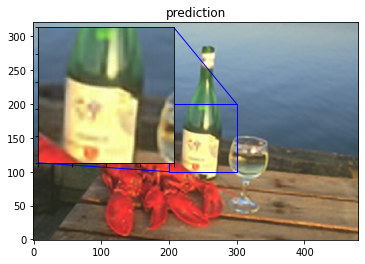

PSNR of low resolution image and high resolution image is 24.9783
PSNR of predict and high resolution is 25.9457


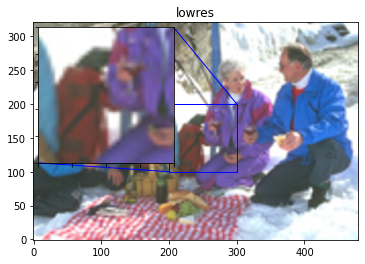

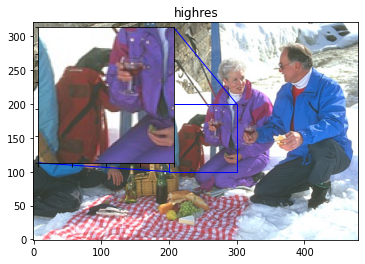

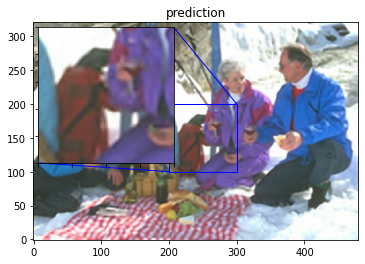

PSNR of low resolution image and high resolution image is 27.7724
PSNR of predict and high resolution is 28.3488


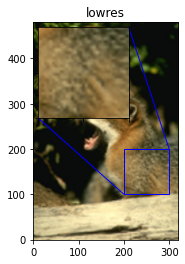

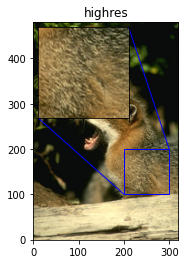

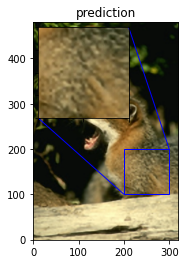

PSNR of low resolution image and high resolution image is 28.0314
PSNR of predict and high resolution is 28.2649


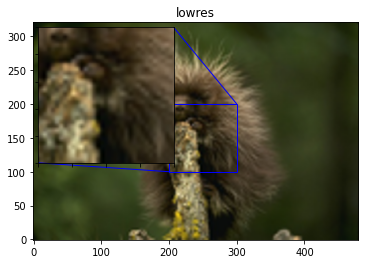

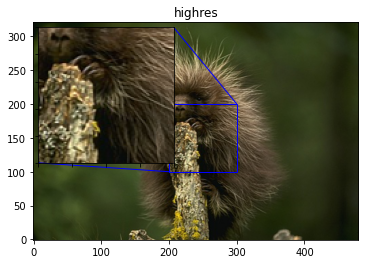

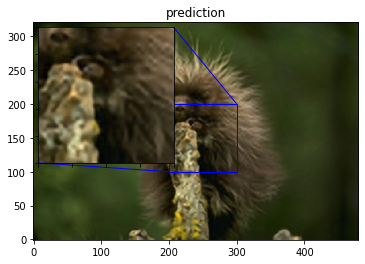

PSNR of low resolution image and high resolution image is 25.7630
PSNR of predict and high resolution is 26.3258


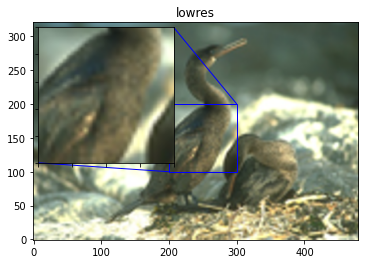

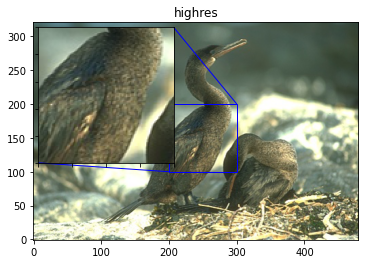

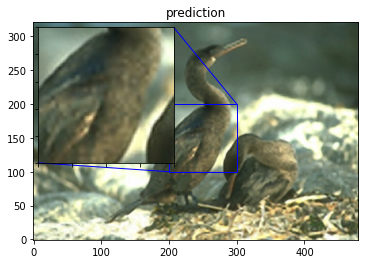

PSNR of low resolution image and high resolution image is 25.7874
PSNR of predict and high resolution is 26.5609


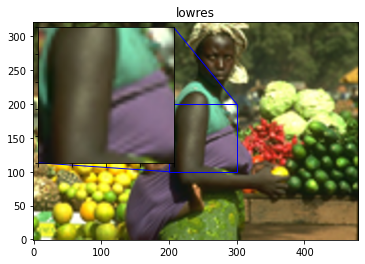

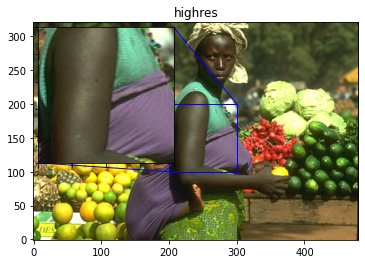

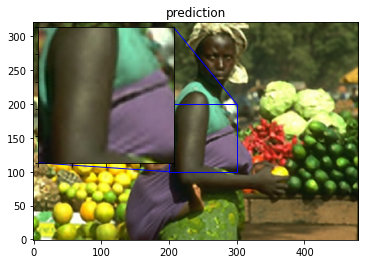

PSNR of low resolution image and high resolution image is 26.2512
PSNR of predict and high resolution is 27.1402


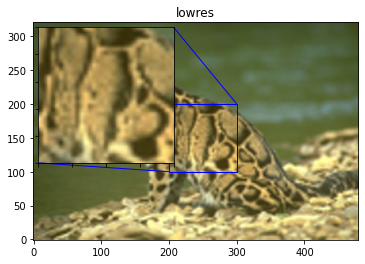

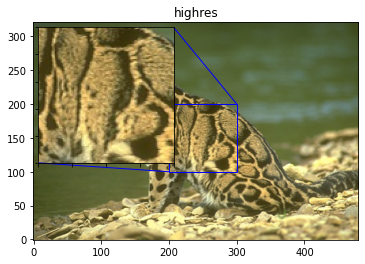

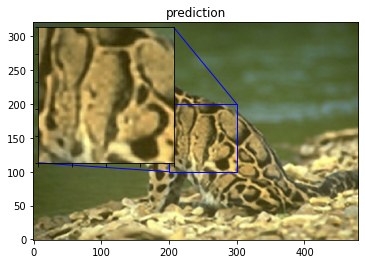

PSNR of low resolution image and high resolution image is 23.3820
PSNR of predict and high resolution is 24.6685


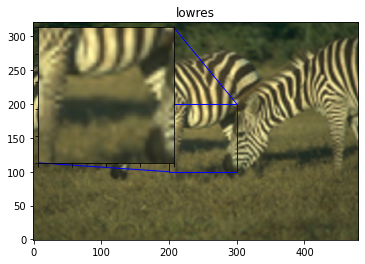

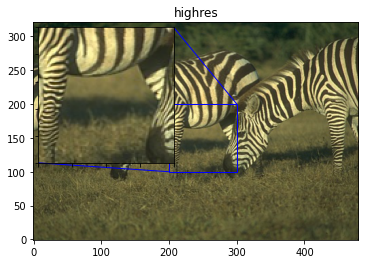

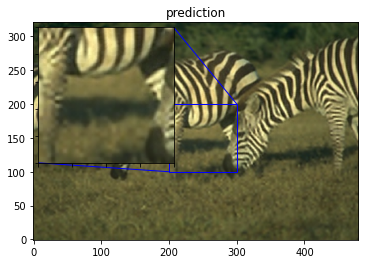

PSNR of low resolution image and high resolution image is 29.8914
PSNR of predict and high resolution is 30.0420


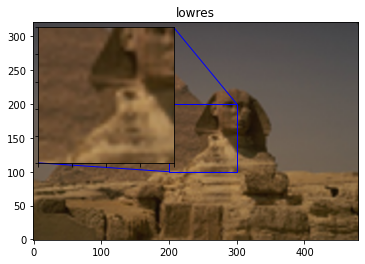

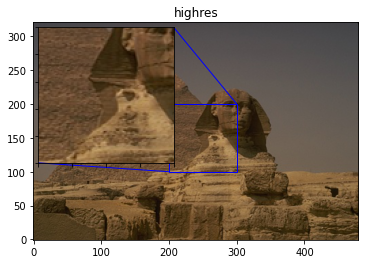

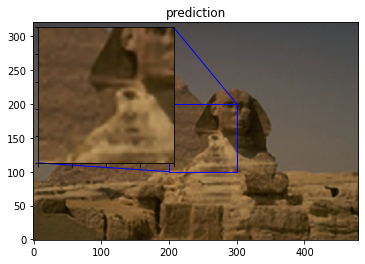

PSNR of low resolution image and high resolution image is 25.1712
PSNR of predict and high resolution is 25.6907


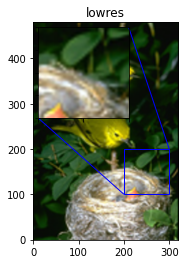

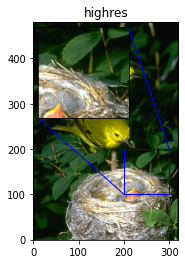

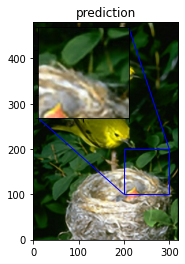

Avg. PSNR of lowres images is 26.6879
Avg. PSNR of reconstructions is 27.3375


In [13]:
total_bicubic_psnr = 0.0
total_test_psnr = 0.0

for index, test_img_path in enumerate(test_img_paths[50:60]):
    img = load_img(test_img_path)
    lowres_input = get_lowres_image(img, upscale_factor)
    w = lowres_input.size[0] * upscale_factor
    h = lowres_input.size[1] * upscale_factor
    highres_img = img.resize((w, h))
    prediction = upscale_image(model, lowres_input)
    lowres_img = lowres_input.resize((w, h))
    lowres_img_arr = img_to_array(lowres_img)
    highres_img_arr = img_to_array(highres_img)
    predict_img_arr = img_to_array(prediction)
    bicubic_psnr = tf.image.psnr(lowres_img_arr, highres_img_arr, max_val = 255)
    test_psnr = tf.image.psnr(predict_img_arr, highres_img_arr, max_val = 255)

    total_bicubic_psnr += bicubic_psnr
    total_test_psnr += test_psnr

    print(
        "PSNR of low resolution image and high resolution image is %.4f" % bicubic_psnr
    )
    print("PSNR of predict and high resolution is %.4f" % test_psnr)
    plot_results(lowres_img, index, "lowres")
    plot_results(highres_img, index, "highres")
    plot_results(prediction, index, "prediction")

print("Avg. PSNR of lowres images is %.4f" % (total_bicubic_psnr / 10))
print("Avg. PSNR of reconstructions is %.4f" % (total_test_psnr / 10))